In [60]:
from collections import defaultdict
from tqdm import tqdm
from itertools import permutations
from nltk.tokenize import word_tokenize, sent_tokenize
from convokit import Corpus, download
import matplotlib.pyplot as plt
import numpy as np
import random
import language_tool_python
from convokit import text_processing
from convokit.transformer import Transformer
# import nltk

In [61]:
PATH = '/Users/kcjordan/Code/cs4350/CANDOR-corpus-cliffhanger'
data_dir = f'{PATH}'

corpus = Corpus(filename=data_dir)

In [62]:
#Example utterance
convo = corpus.random_conversation()
for utt in convo.iter_utterances():
    if utt.meta['questions'] > 0:
        before = utt
        break
print(before)

Utterance(id: '263955', conversation_id: c4d50c68-5b6d-4180-a693-25cab706ada4, reply-to: 263954, speaker: Speaker(id: '5f4fd45ac62ac40f6bdf8ee1', vectors: [], meta: ConvoKitMeta({'sex': 'male', 'politics': 2.0, 'race': 'black_or_african_american', 'edu': 'masters_degree', 'employ': 'unemployed', 'age': 28.0})), timestamp: 203.14, text: 'Yeah. Hello. Yeah how you doing?', vectors: [], meta: ConvoKitMeta({'turn_id': 1, 'start': 203.14, 'stop': 211.55, 'interval': -0.7200000000000273, 'delta': 8.410000000000025, 'questions': 1, 'end_question': True, 'overlap': True, 'n_words': 6}))


# Transformer

In [63]:
class OpennessRuleScore(Transformer):
    """
    A simple transformer to count all the usage of "open" or "closed" indicator words in the last question posed.

    :param obj_type: type of Corpus object to calculate: 'conversation', 'speaker', or 'utterance', default to be 'utterance'
    :param input_field: Input fields from every utterance object. Will default to reading 'utt.text'. If a string is provided, than consider metadata with field name input_field.
    :param output_field: field for writing the computed output in metadata. Will default to write to utterance metadata with name 'openness'.
    :param input_filter: a boolean function of signature `input_filter(utterance, aux_input)`. attributes will only be computed for utterances where `input_filter` returns `True`. By default, will always return `True`, meaning that attributes will be computed for all utterances.
    :param verbosity: frequency at which to print status messages when computing attributes.
    """

    def __init__(
        self,
        obj_type='utterance',
        output_field='openness_score',
        input_field=None,
        input_filter=None,
        verbosity=10000,
    ):
        if input_filter:
            if len(signature(input_filter).parameters) == 1:
                self.input_filter = lambda utt: input_filter(utt)
            else:
                self.input_filter = input_filter
        else:
            self.input_filter = lambda utt: True
        self.obj_type = obj_type
        self.input_field = input_field
        self.output_field = output_field
        self.verbosity = verbosity
        self.open = [
            "what",
            "do",
            "does",
            "wonder",
            "think",
            "you",
            "why",
            "how",
            "should",
            "your"]
        self.closed = [
            "I",
            "right",
            "know",
            "can",
            "or",
            "much",
            "many",
            "long",
            "have",
            "where",
            "when",
            "who",
            "which",
            "yes",
            "yeah",
            "no"]

    def _print_output(self, i):
        return (self.verbosity > 0) and (i > 0) and (i % self.verbosity == 0)

    def find_last_question(self, text):
        #we return the last question
        sent = sent_tokenize(text)
        for sent_tok in reversed(sent):
            if sent_tok[-1]=="?":
                return sent_tok
        #no question in this utterance
        return ""

    def rule_score_for_utterance(self, text):
        score = 0
        for el in text:
            if el in self.closed:
                score -=1
            if el in self.open:
                score +=1
        return score

    def transform(self, corpus: Corpus) -> Corpus:
        """
        Score the amount of "openness_score" and annotate in the corresponding object metadata fields.

        :param corpus: Corpus
        :return: the corpus
        """
        if self.obj_type == 'utterance':
          total = len(list(corpus.iter_utterances()))

          for idx, utterance in enumerate(corpus.iter_utterances()):
              if self._print_output(idx):
                  print(f"%03d/%03d {self.obj_type} processed" % (idx, total))
              if not self.input_filter(utterance):
                  continue
              if self.input_field is None:
                  text_entry = utterance.text
              elif isinstance(self.input_field, str):
                  text_entry = utterance.meta(self.input_field)
              if text_entry is None:
                  continue

              sent = self.find_last_question(text_entry.lower())
              tok = word_tokenize(sent)
              catch = self.rule_score_for_utterance(tok)

              utterance.add_meta(self.output_field, catch)

        elif self.obj_type == 'conversation':
          total = len(list(corpus.iter_conversations()))

          for idx, convo in enumerate(corpus.iter_conversations()):
            if self._print_output(idx):
                print(f"%03d/%03d {self.obj_type} processed" % (idx, total))

            if not self.input_filter(convo):
                continue

            if self.input_field is None:
                utt_lst = convo.get_utterance_ids()
                text_entry = ' '.join([corpus.get_utterance(x).text for x in utt_lst])
            elif isinstance(self.input_field, str):
                text_entry = convo.meta(self.input_field)
            if text_entry is None:
                  continue

            sent = self.find_last_question(text_entry.lower())
            tok = word_tokenize(sent)
            catch = self.rule_score_for_utterance(tok)

            convo.add_meta(self.output_field, catch)

        elif self.obj_type == 'speaker':
          total = len(list(corpus.iter_speakers()))

          for idx, sp in enumerate(corpus.iter_speakers()):
            if self._print_output(idx):
                print(f"%03d/%03d {self.obj_type} processed" % (idx, total))

            if not self.input_filter(sp):
                continue

            if self.input_field is None:
                utt_lst = sp.get_utterance_ids()
                text_entry = ' '.join([corpus.get_utterance(x).text for x in utt_lst])
            elif isinstance(self.input_field, str):
                text_entry = sp.meta(self.input_field)
            if text_entry is None:
                  continue

            sent = self.find_last_question(text_entry.lower())
            tok = word_tokenize(sent)
            catch = self.rule_score_for_utterance(tok)

            sp.add_meta(self.output_field, catch)

        else:
          raise KeyError('obj_type must be utterance, conversation, or speaker')


        if self.verbosity > 0:
            print(f"%03d/%03d {self.obj_type} processed" % (total, total))
        return corpus

In [64]:
opencounter = OpennessRuleScore(obj_type='utterance')
opencounter.transform(corpus)

10000/527869 utterance processed
20000/527869 utterance processed
30000/527869 utterance processed
40000/527869 utterance processed
50000/527869 utterance processed
60000/527869 utterance processed
70000/527869 utterance processed
80000/527869 utterance processed
90000/527869 utterance processed
100000/527869 utterance processed
110000/527869 utterance processed
120000/527869 utterance processed
130000/527869 utterance processed
140000/527869 utterance processed
150000/527869 utterance processed
160000/527869 utterance processed
170000/527869 utterance processed
180000/527869 utterance processed
190000/527869 utterance processed
200000/527869 utterance processed
210000/527869 utterance processed
220000/527869 utterance processed
230000/527869 utterance processed
240000/527869 utterance processed
250000/527869 utterance processed
260000/527869 utterance processed
270000/527869 utterance processed
280000/527869 utterance processed
290000/527869 utterance processed
300000/527869 utterance

In [65]:
after = corpus.get_utterance(before.id)
print(after.text)
print(after)

Yeah. Hello. Yeah how you doing?
Utterance(id: '263955', conversation_id: c4d50c68-5b6d-4180-a693-25cab706ada4, reply-to: 263954, speaker: Speaker(id: '5f4fd45ac62ac40f6bdf8ee1', vectors: [], meta: ConvoKitMeta({'sex': 'male', 'politics': 2.0, 'race': 'black_or_african_american', 'edu': 'masters_degree', 'employ': 'unemployed', 'age': 28.0})), timestamp: 203.14, text: 'Yeah. Hello. Yeah how you doing?', vectors: [], meta: ConvoKitMeta({'turn_id': 1, 'start': 203.14, 'stop': 211.55, 'interval': -0.7200000000000273, 'delta': 8.410000000000025, 'questions': 1, 'end_question': True, 'overlap': True, 'n_words': 6, 'openness_score': 1}))


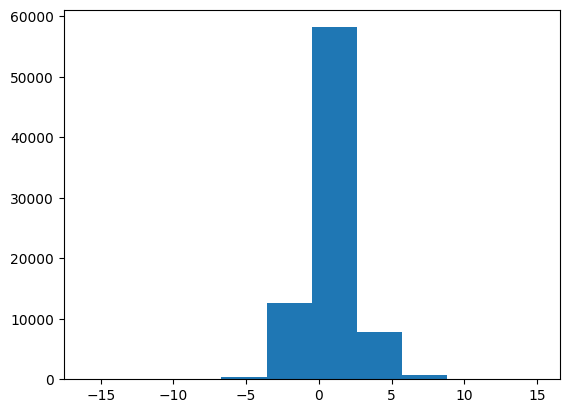

In [66]:
open = []
text = []
max = (0, "")
min = (0, "")
for utt in corpus.iter_utterances():
    if utt.meta['questions'] > 0:
        score = utt.meta['openness_score']
        open.append(score)
        if score > max[0]:
            max = (score, utt.text)
        if score < min[0]:
            min = (score, utt.text)
        if score == 0:
            text.append(utt.text)

plt.hist(open)
plt.show()